# Analysis of Audience participant body sway, MusicLab Copenhagen


Generation of plots for Audience Motion paper

In [1]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

import matplotlib.gridspec as gridspec

In [2]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am
%aimport frf

In [3]:
%reload_ext autoreload

In [4]:
# https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [5]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [6]:
internal_Part = general_loc + 'Participants_internal/'

In [7]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [8]:
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
sF = 10

In [9]:
concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [10]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


One of the unfortunate characteristics of the cellphone measurements is their inconsistent sample rates and frequent gaps. Measurements per device were transmitted in 60 s batches, however there were (for as of yet undetermined reasons) often gaps between batches, sometimes of several seconds. These frequent discontinuities complicate how this data can be treated. Some steps taken were necessary compromises because of these measurement issues. There were also discontinuities from participants turning off the app to answer questions (remote participants only) or during intermission. To handle these gaps with care throughout these analyses, we inserted NaN values in any gaps lasting more than a second before resampling the ACC measurements to get Quantity of Motion measures on common timestamp values.

Lastly there was some data loss from phones lossing power or th app being accidentally or incidentally turned off/closed.

The individual participants accelerometer measurements during the concert experiment were resampled to matching timestamps at 50 Hz

In [11]:
tic = time.time()

# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
trial_dic = {}
for i, participant in alignedParts.iterrows(): # .loc[21:21,:]
    part = participant['Participant_Code']
#     print(part)
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = am.gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
#         aud_df.loc[:,part] = b*6 # could go down to 5, based on distributions (high end)
        trial_dic[part] = pd.Series(index=dt_ct,data=b*5)
    else:
        trial_dic[part] = pd.Series(index=dt_ct,data=b)
print(time.time()-tic)   
aud_df = pd.concat(trial_dic,axis=1)
print(time.time()-tic)
aud_df.index = dt_ct

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x

146.6680920124054
146.76051902770996


In [12]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


In [13]:
aud_df.index = (ts_ct/1000).round(1)
ori_aud_df = aud_df.copy()
# ori_aud_df.index = (ts_ct/1000).round(1) # convert to seconds from milliseconds


In [14]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(aligned_Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(aligned_Part_Codes),:].reset_index(drop = True)

In [15]:
#aligned_Part_Codes[:85], aligned_Part_Codes[85:]
AUD = aud_df.loc[:,aligned_Part_Codes[:85]].copy()
AUD['Virtual'] = np.nan
AUD['Virtual.'] = np.nan
AUD['Virtual..'] = np.nan
AUD['Virtual...'] = np.nan
AUD['Virtual....'] = np.nan
AUD = pd.concat([AUD,aud_df.loc[:,aligned_Part_Codes[85:]].copy()],axis=1)

[-691.24, 8352.060000000001]


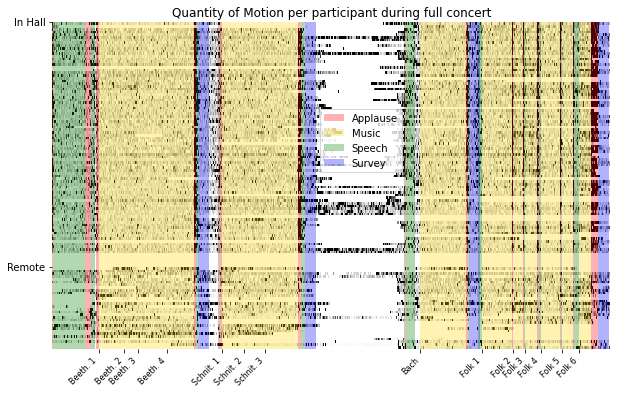

In [16]:
seg_start = concert_times.iloc[0,:].Time_s #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[51,:].Time_s + 200
print([seg_start,seg_end])
Event_Pallet={'Applause':'red','Music':'gold','Speech':'green','Survey':'blue','Synch':'purple'}
alpha_factor = 0.3

# seg_times = Main_concert_times.copy()
seg_df = AUD.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [10,6])
chart = sns.heatmap(data=-seg_df.transpose(), ax=ax1,vmin=-0.5, vmax=0,cbar=False, cmap=cm.gray)

seg_times = concert_times.loc[concert_times['Event_Type'].isin(['Music'])]
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
plt.xticks(new_xticks,seg_times.Shorter_tag, fontsize=8, ha='right')
ax1.tick_params(axis='x', labelrotation=45)
seg_times = concert_times#.loc[concert_times['Event_Type'].isin(['Speech','Music'])]
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
new_dur = len(seg_df)*(seg_times['Event_Duration'])/(seg_end -seg_start)
new_dur_survey = len(seg_df)*(180)/(seg_end -seg_start)
xrange = [0,180]

ax1.margins(0)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='red',label="Applause",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1,  facecolor='gold',label="Music",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='green',label="Speech",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='blue',label="Survey",alpha=alpha_factor)

ax1.legend(loc='upper left', bbox_to_anchor=(0.47,0.75))


alpha_factor = 0.3
yrange = [0,120.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = new_xticks[i]
    ej = new_xticks[i] + new_dur[i]
    if r['Event_Type'].startswith('Applause'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=alpha_factor)
    if r['Event_Type'].startswith('Musi'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='gold', alpha=alpha_factor)
    if r['Event_Type'].endswith('Speech'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=alpha_factor)
    if r['Event_Type'].startswith('Survey'):
        ej = new_xticks[i] + new_dur_survey
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=alpha_factor)

ax1.set_yticks([0,90])
ax1.set_yticklabels(['In Hall','Remote'])
# ax1.set_xticklabels(cmoments['Event'])
plt.title('Quantity of Motion per participant during full concert')
plt.savefig('./plots/qom_n_full_colour.png', bbox_inches = 'tight',dpi = 196)
plt.show()


# Power Spectrum analysis

In [139]:
def get_spectrogram(datain,F,W,J,scale='log'):
    '''Makes a spectrogram of the given data.
    #
    df: dataframe with data
    F: sampling frequency
    W: Window size
    J: Separation between windows
    #
    output: if input is Series output is a signle DF with spectrogram
            if intput is DF the output is dictionary with one spectrogram per column of the input dataframe
    '''
    K = range(0,len(datain)-W,J) # starting point for the windows
    K0 = [int(x+W/2) for x in K] # placing them in the middle point timestamp
    new_index = [datain.index[x] for x in K0] # extracting those timestamps
    col_freqs = [x*F/W for x in range(int(W/2)+1) ] # values of resolved freqs
    #   print(len(new_index),len(col_freqs))
    han = np.hanning(W)
    #dic = {'window_size':W,'sampling_frequency':F}
    #
    dic = {}
    for col in datain.columns:
        fourier = np.zeros((len(new_index),len(col_freqs)))
        temp = np.zeros((1,int(W/2)+1))
        j = 0
        D = datain[col]
#         D = D.diff() # discrete derivative
        D = D.dropna() # discarding nans and concatenating
        if len(D)==0:
            continue
        #   
        K0 = range(0,len(D)-W,J) # starting point for the windows
        for T0 in K0:
            data0 = D.iloc[T0:T0+W]*han
            if scale=='log':
                temp = 10*np.log10(2*abs(np.fft.fft(data0,axis=0)))
            elif scale=='abs':
                temp = abs(np.fft.fft(data0,axis=0))
            fourier[j,:] = temp[:int(W/2)+1]
            j = 1 + j
            #
        res = pd.DataFrame(fourier,index=new_index,columns=col_freqs)
#         res1 = res / (res.columns) # multiplicative adjustment for discrete derivative
        dic[col] = res#1      
        #print('Ready with ',col)
    output = dic
    #
    return output
#
def get_meanpowerspectrum(datain,F,W,J,scale='log'):
    # Obtained average spectrogram using the previous function
    spectrogram = get_spectrogram(datain,F,W,J,scale)
    dic = {}
    for key in spectrogram:
        dic[key] = spectrogram[key].mean(axis=0)
    output = pd.DataFrame(dic,index=dic[key].index)
    return output
#
#

In [140]:
sF = 10
FrameSize = 2**9
HopSize = 100

ETypes = ['Music','Survey','Speech','Applause']
minDur = 60 # s
MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')

Specs = {}
for i,r in MTs.iterrows():
    sigs=ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    Specs[r['Shorter_tag']] = get_meanpowerspectrum(sigs,sF,FrameSize,HopSize,scale='abs')
    

In [141]:
Specs.keys()

dict_keys(['Speech MC1', 'Speech MC2', 'Claps 1.1', 'Speech MC3', 'Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Survey 1', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Claps 5', 'Survey 2', 'Speech MC5', 'Bach', 'Survey 3', 'Folk 1', 'Folk 2', 'Folk 3', 'Folk 4', 'Folk 5', 'Folk 6', 'Claps 14', 'Survey 4'])

Combine power spectra per participant per meta event category. Note this needs to handle partial missing data from some participants

In [142]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
df_means = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev_tag),:]
    sigs = []
    for i,r in MTs.iterrows():
         sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    df_means.loc[ev_tag,:] = fullset.mean()
df_means

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
Beethoven,0.069311,NaN,0.094418,0.101837,0.07339,0.108468,0.079436,0.086562,0.078947,0.132908,...,0.050851,0.209203,0.106644,0.164509,0.342741,0.182293,NaN,0.084129,0.272131,NaN
Schnittke,NaN,NaN,0.09243,0.143013,0.08211,0.1171,0.071236,0.08482,0.083305,0.106298,...,NaN,0.324734,0.160088,0.174884,0.288465,0.168656,NaN,NaN,0.142764,NaN
Bach,0.056344,0.135229,0.095909,0.124146,0.076237,0.103214,0.072805,0.075133,0.063821,0.103792,...,NaN,NaN,0.161927,NaN,NaN,NaN,0.041645,0.080859,0.044488,0.064046
Folk,0.090395,0.110848,0.12164,0.16044,0.102084,0.103741,0.122425,0.108638,0.077485,0.166454,...,0.13115,NaN,0.31208,1.033047,NaN,NaN,NaN,0.099888,0.068717,0.11593
Survey,0.209239,0.276741,0.138638,0.390651,0.154346,0.20982,0.193861,0.116464,0.160078,0.598902,...,2.63744,0.300593,NaN,0.21808,0.455517,NaN,NaN,0.257953,0.263718,0.225292
Speech,0.246232,0.292039,0.295855,0.372476,0.145761,0.229551,0.146598,0.182625,0.139083,0.437855,...,0.26774,0.461094,0.136921,0.538927,0.798314,0.263668,0.026651,0.132056,0.271759,0.362781
Clapping,0.797674,0.802796,0.90859,0.970213,0.477492,1.184541,1.074963,0.929972,0.72639,1.03579,...,0.235498,0.504528,0.136179,0.229127,0.515613,0.462726,0.443953,0.278389,0.400149,0.301939


In [143]:
ev = 'Speech'
sub_evs = Main_concert_times.query('Event.str.startswith(@ev)and Event_Duration > @minDur')
sub_evs['Shorter_tag']

Datetime
2021-10-26 17:36:53    Speech MC1
2021-10-26 17:38:56    Speech MC2
2021-10-26 17:47:02    Speech MC3
2021-10-26 19:11:46    Speech MC5
Name: Shorter_tag, dtype: object

In [144]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
SuperSpecs = {}
for ev in ev_tags:
    sub_evs = Main_concert_times.query('Event.str.startswith(@ev)and Event_Duration > @minDur')
    Parts = list(df_means.columns[df_means.loc[ev].notna()])
    df_parts = pd.DataFrame(columns = Parts)
    for partID in Parts:
        df=pd.DataFrame()
        for s in sub_evs['Shorter_tag']:
            if partID in Specs[s].columns:
                df[s] = Specs[s].loc[:,partID].copy()
        df_parts[partID] = df.mean(axis=1)
    SuperSpecs[ev]=df_parts.copy()

In [145]:
D_beethoven = Specs['Beeth. 1'].loc[:,Specs['Beeth. 1'].columns.str.startswith('A')].T.melt(var_name='Frequency', value_name='Power')
D_beethoven

,Frequency,Power
0,0.0,16.696936
1,0.0,22.158357
2,0.0,28.188262
3,0.0,17.138646
4,0.0,24.409591
...,...,...
21069,5.0,0.695742
21070,5.0,0.220399
21071,5.0,0.646446
21072,5.0,0.450752


In [146]:
D_evs = []
for ev in SuperSpecs.keys(): # just in hall
    df = SuperSpecs[ev].loc[:,SuperSpecs[ev].columns.str.startswith('A')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
D = pd.concat(D_evs,axis=0)
D.replace([np.inf, -np.inf], np.nan, inplace=True)
D = D.dropna()

D_evs = []
for ev in Specs.keys(): # just in hall
    df = Specs[ev].loc[:,Specs[ev].columns.str.startswith('A')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
Ds = pd.concat(D_evs,axis=0)
Ds.replace([np.inf, -np.inf], np.nan, inplace=True)
Ds = Ds.dropna()



In [147]:
D_evs = []
for ev in SuperSpecs.keys(): # just Remote
    df = SuperSpecs[ev].loc[:,SuperSpecs[ev].columns.str.startswith('B')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
G = pd.concat(D_evs,axis=0)
G.replace([np.inf, -np.inf], np.nan, inplace=True)
G = G.dropna()

D_evs = []
for ev in Specs.keys(): # just Remote
    df = Specs[ev].loc[:,Specs[ev].columns.str.startswith('B')].T.melt(var_name='Frequency', value_name='Power')
    df['Event'] = ev
    D_evs.append(df)
Gs = pd.concat(D_evs,axis=0)
Gs.replace([np.inf, -np.inf], np.nan, inplace=True)
Gs = Gs.dropna()


Fernando's original plots actually reported the 95th CI as constructed by 2 * standard error, not the straight standard error as he claimed.

Also we should cite pinguine and seaborn libraries for the visualisations



In [154]:

# General aspect of figure
plt.figure(figsize=(6, 8),sharex=True)
#
plt.subplot(3, 1, 1)
Event_palette={'Beethoven':'orange','Schnittke':'orange','Bach':'orange','Folk':'orange',
        'Clapping':'red','Speech':'green','Survey':'blue','Synch':'purple'}
ax = sns.lineplot(data=D, x='Frequency',y='Power',hue='Event',errorbar='ci',err_style='band', palette=Event_palette)
ax.set(xlim=(0,5), ylim=(0, 8))
ax.set_xticks(np.arange(0,5,0.2))
ax.set_title('Average power spectrum (ci 95%) for in Hall Participants')
ax.grid()

plt.subplot(3, 1, 2)
sub_evs = ['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach',]
Ds_sub = Ds.query('Event in @sub_evs')
ax = sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar='ci',err_style='band', palette='Oranges')
ax.legend(loc='upper right')
ax.set(xlim=(0,5), ylim=(0, 1.5))
ax.grid()

plt.subplot(3, 1, 3)
sub_evs = ['Folk 1', 'Folk 2', 'Folk 3', 'Folk 4', 'Folk 5', 'Folk 6']
Ds_sub = Ds.query('Event in @sub_evs')
ax = sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar='ci',err_style='band', palette='Oranges')
ax.set(xlim=(0,5), ylim=(0, 2))
ax.grid()
plt.tight_layout()
plt.savefig('./plots/spectrum_Hall.png', bbox_inches = 'tight',dpi = 196)

#
plt.show()

AttributeError: Figure.set() got an unexpected keyword argument 'sharex'

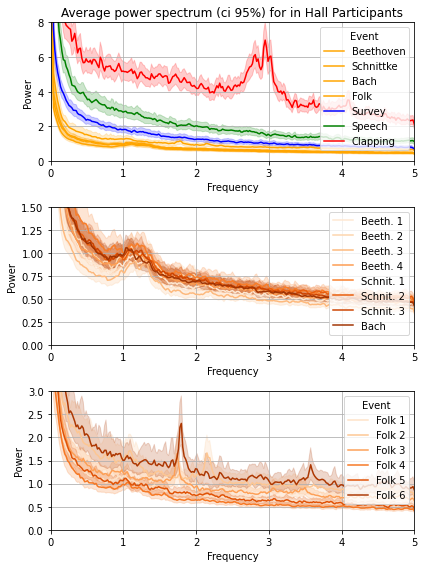

In [153]:

# General aspect of figure
plt.figure(figsize=(6, 8))
#
plt.subplot(3, 1, 1)
Event_palette={'Beethoven':'orange','Schnittke':'orange','Bach':'orange','Folk':'orange',
        'Clapping':'red','Speech':'green','Survey':'blue','Synch':'purple'}
ax = sns.lineplot(data=D, x='Frequency',y='Power',hue='Event',errorbar='ci',err_style='band', palette=Event_palette)
ax.set(xlim=(0,5), ylim=(0, 8))
ax.set_title('Average power spectrum (ci 95%) for in Hall Participants')
ax.grid()

plt.subplot(3, 1, 2)
sub_evs = ['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach',]
Ds_sub = Ds.query('Event in @sub_evs')
ax = sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar='ci',err_style='band', palette='Oranges')
ax.legend(loc='upper right')
ax.set(xlim=(0,5), ylim=(0, 1.5))
ax.grid()

plt.subplot(3, 1, 3)
sub_evs = ['Folk 1', 'Folk 2', 'Folk 3', 'Folk 4', 'Folk 5', 'Folk 6']
Ds_sub = Ds.query('Event in @sub_evs')
ax = sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar='ci',err_style='band', palette='Oranges')
ax.set(xlim=(0,5), ylim=(0, 3))
ax.grid()
plt.tight_layout()
plt.savefig('./plots/spectrum_Hall.png', bbox_inches = 'tight',dpi = 196)

#
plt.show()

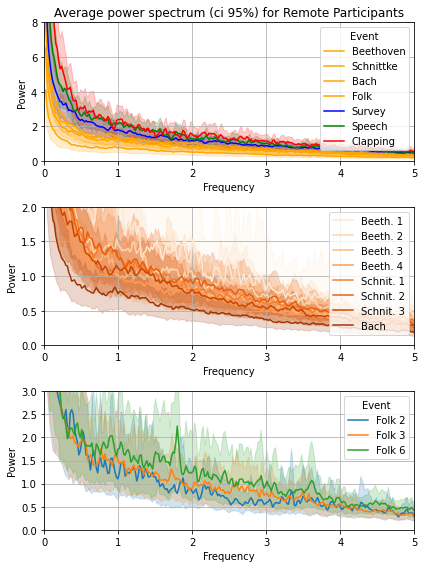

In [128]:
# 2. PLOTTING 
#
# General aspect of figure
plt.figure(figsize=(6, 8))
#
plt.subplot(3, 1, 1)
Event_palette={'Beethoven':'orange','Schnittke':'orange','Bach':'orange','Folk':'orange',
        'Clapping':'red','Speech':'green','Survey':'blue','Synch':'purple'}
# errorbar=('se',2)
ax = sns.lineplot(data=G, x='Frequency',y='Power',hue='Event',errorbar='ci',err_style='band', palette=Event_palette)
ax.set(xlim=(0,5), ylim=(0, 8))
ax.set_title('Average power spectrum (se) for Remote Participants')
ax.grid()

plt.subplot(3, 1, 2)
sub_evs = ['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach',]
Ds_sub = Gs.query('Event in @sub_evs')
ax = sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar='ci',err_style='band', palette='Oranges')
ax.legend(loc='upper right')
ax.set(xlim=(0,5), ylim=(0, 2))
ax.grid()

plt.subplot(3, 1, 3)
# sub_evs = ['Folk 1', 'Folk 2', 'Folk 3', 'Folk 4', 'Folk 5', 'Folk 6']
sub_evs = ['Folk 2', 'Folk 3', 'Folk 6']

Ds_sub = Gs.query('Event in @sub_evs')
ax = sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar='ci',err_style='band')
ax.set(xlim=(0,5), ylim=(0, 3))
ax.grid()
plt.tight_layout()
plt.savefig('./plots/spectrum_Remote.png', bbox_inches = 'tight',dpi = 196)

#
plt.show()

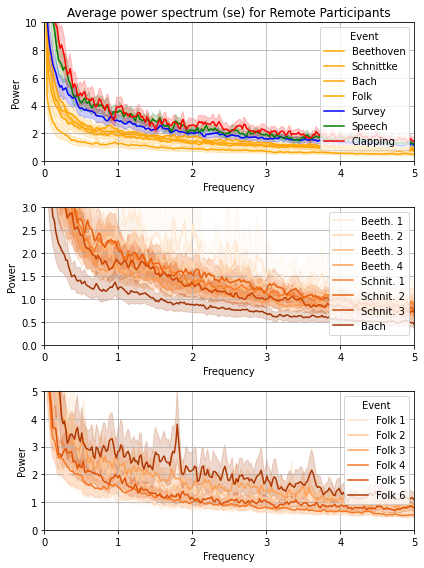

In [152]:
# 2. PLOTTING 
#
# General aspect of figure
plt.figure(figsize=(6, 8))
#
plt.subplot(3, 1, 1)
Event_palette={'Beethoven':'orange','Schnittke':'orange','Bach':'orange','Folk':'orange',
        'Clapping':'red','Speech':'green','Survey':'blue','Synch':'purple'}
# errorbar=('se',2)
ax = sns.lineplot(data=G, x='Frequency',y='Power',hue='Event',errorbar='se',err_style='band', palette=Event_palette)
ax.set(xlim=(0,5), ylim=(0, 10))
ax.set_title('Average power spectrum (se) for Remote Participants')
ax.grid()

plt.subplot(3, 1, 2)
sub_evs = ['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Schnit. 1', 'Schnit. 2', 'Schnit. 3', 'Bach',]
Ds_sub = Gs.query('Event in @sub_evs')
ax = sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar='se',err_style='band', palette='Oranges')
ax.legend(loc='upper right')
ax.set(xlim=(0,5), ylim=(0, 3))
ax.grid()

plt.subplot(3, 1, 3)
sub_evs = ['Folk 1', 'Folk 2', 'Folk 3', 'Folk 4', 'Folk 5', 'Folk 6']
# sub_evs = ['Folk 2', 'Folk 3', 'Folk 6']

Ds_sub = Gs.query('Event in @sub_evs')
# ax = sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar='se',err_style='band')
ax = sns.lineplot(data=Ds_sub, x='Frequency',y='Power',hue='Event',errorbar='se',err_style='band', palette='Oranges')
ax.set(xlim=(0,5), ylim=(0, 5))
ax.grid()
plt.tight_layout()
plt.savefig('./plots/spectrum_Remote.png', bbox_inches = 'tight',dpi = 196)

#
plt.show()

# Pairwise Correlation analysis and plots

Pairwise correlations were performed on 10Hz absolute Jerk values (1st order difference of ACC resampled at 10 Hz or 10 Hz resampling of absolut jerk from first order difference on 50 Hz) to assess simultaneous motion. 

First pairwise correlations between all participants were performed to assess the contribution of the shared stimulus (the music performance and conditions) across the group in when they moved more or less. 

By sitting on the chest, these sensors have a chance of catching something of head and limb movements as well has changes of position in the torso, however interpretation of the scale of these motions from the measurements is impossible when their source cannot be distinguished. For example, applause can be distinguished because the resultant sensor motion is very distinct and proportional to the intensity of clapping, at least between rounds from individual participants. In contrast, the motion resultant from answering multiple choice questions on the paper surveys was much more variable in timing, shape, and scale, including factors from their posture (leaning forward to read and write on lap or sitting straight and writing against raised paper in hand) and writing gestures (dash, checkmark, or filled square). Besides ambiguity in the types of movements behind the measurements captured, the amount of time moving was relatively low throughout the concert. Most of these measurements stayed close to the noise floor as the audience sat attentively still, with only the occasional jump of values. In otherwords, the motion signal in these measurements is very sparse, and our priority is in capturing whether any signal was occuring at the same time, not whether the movements were of a similar scale through all the ambiguities of this hanging chest acc sensor.

We opted to use the spearman correlation to capture shared motion on these time series because of the indeterminent and sparse quality of the motion signals. By using rank instead of actual measure values, the metric reduce potential scaling differences in the rare and uneven (and unevenly captured) bursts of motion, while the high frequence noise-level variation at 10 hz reduce accidental inflations. In this sense, the spearman correlation values are a measure of how much simultaneous motion occurred between two people while a piece was performed (ie when moments with high rank coincided), with sensical low values for most peices. Note that we aren't using Spearman correlations with a test of significance per pair based on the samples or duration of these time series. Spearman's rho is only a metric of how often a pair of audience members simultaneously moved, not matter the kind of motion. 

These pairwise correlations are used to test two different influences on the motion of this audience: 1) the shared stimulus/activity across the whole in-hall audience, 2) the influence of audience members on each other, given where they were seated and whether they knew each other. In both cases, we are intersted to see if the music and non-musical concert experiment events showed relatively more or less effect on coincidental motion. 

The first use of the pairwise correlations was to evaluate whether the patterns of motion reflected the shared stimulus of the performance and concert hall for in hall participants. For any given segment of the concert (2 minutes length or longer), were in hall participants significantly more simultaneous in their movements than should happen by chance? Representing the coincidental motion performed was the complete comparison set between every participant with motion measured for that segment, audience member A's 10 Hz QoM time series correlated with every other audience members motion as sampled at that same time. As the types of movements being performed change the opportunity for coincidence, we constructed alternative distributions of pairwise comparisons between each audience member for that event against the motion recorded from every other audience participant at similar but different segment. For the multimovment music pieces, the false alternative was constructed between successive movements in the same section (ex: 1->2, 2->3, 3->1), while the Bach was correlated with the third movement of the Beethoven (slow) as the most similar in tempo and dynamics. The Survey sections were similarly rotated for false alternative distributions, as were the speech segments and applause. For all these altenatives pairwise correlations, the longer segment signals had to be truncated for comparison. 

A last note on interpreting coincidental motion as measured here: these signals were aligned to within 200 ms, or two samples at 10 Hz. While this too temporally blurry to capture the precision of alignment in motion between musicians, the measurable motions performed by the audience generally last less than 100 ms, giving a chance for overlap even if signal alignment is less than performed. Again, for an evalutaion of coincidental motion without focus on specific actions, this alignment quality is sufficient for capturing simultenaity between audience members.

 

In [124]:
def ctransform(x):
    """Copula transformation (empirical CDF)
    cx = ctransform(x) returns the empirical CDF value along the first
    axis of x. Data is ranked and scaled within [0 1] (open interval).
    """
    #
    xi = np.argsort(np.atleast_2d(x))
    xr = np.argsort(xi)
    cx = (xr+1).astype(float) / (xr.shape[-1]+1)
    return cx
#
#
def copnorm(df):
    """Copula normalization
    #   
    cx = copnorm(x) returns standard normal samples with the same empirical
    CDF value as the input. Operates along the last axis.
    """
    #cx = sp.stats.norm.ppf(ctransform(df.T.values))
    df_out = df.copy()
    for c in df.columns:
        data = df[c]
        ix = ~data.isna()
        data = data[ix]
        cx = sp.special.ndtri(ctransform(data.T.values))[0]
        df_out.loc[ix,c] = cx
    #res = pd.DataFrame( data=cx, columns=df.index, index=df.columns)
    #res = res.T
    return df_out
#
#
def calc_corr_subject(df, name, meta=0, method='pearson', dyads=False):
    """Function to calculate the correlation between the movement patterns of audience.
    Inputs -
        df: Pandas dataframe with data
        name: Name (string) to label the data
        meta: Additional metadata that one may need to add to the outcomes
        method: 'pearson' or 'spearman', related to how to compute the correlation value
        dyads: Boolean, if True, the correlation is delivered per dyad.
               if False, the function computes the average for each participant.
    """
    # compute correlation using Pandas built-in functionality
    corr = df.corr(method=method).stack()
    # remove corr between peoeple and themselves
    # (this keeps two copies of each dyad, but is ok for next calculations)
    corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]
    corr = corr.reset_index()
    corr.columns = ['ID','ID2','Correlation']
    # if dyads==False, calculate mean for each subject
    if not dyads:
        corr = corr.drop(columns='ID2').groupby('ID').mean()
        corr.columns = [name]
    #
    # if dyads==True, give the values per dyad and merge with metadata
    if dyads:
        corr = pd.merge(corr,meta)
        corr['Piece'] = name
    #
    return corr
#

